# Installing dependencies

In [ ]:
!pip install geopandas
!pip install sentinelhub
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Specifying file tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/diploma/sentinel_2_dataset.h5 ./

In [ ]:
!cp /content/drive/MyDrive/diploma/germ_crop_mask.npy ./

In [ ]:
!cp /content/drive/MyDrive/diploma/afro_crop_mask.npy ./

In [ ]:
!cp /content/drive/MyDrive/germany_sentinel2_data/dlr_fusion_competition_germany_train_source_sentinel_2/dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/clp.npy ./

In [ ]:
!cp /content/drive/MyDrive/germany_sentinel2_data/dlr_fusion_competition_germany_train_source_sentinel_2/dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/bbox.pkl ./

In [ ]:
!cp /content/drive/MyDrive/germany_sentinel2_data/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson ./

In [ ]:
bands_path = 'sentinel_2_dataset.h5'
germ_mask_path = 'germ_crop_mask.npy'
afro_mask_path = 'afro_crop_mask.npy'
cloud_prob_path = 'clp.npy'
labels_path = 'labels.geojson'

# Defining Keras Data Sequence

In [ ]:
from tensorflow import keras
import math
from random import shuffle, seed
import pickle
# import sentinelhub
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import features
import h5py
import os

CLASSES = ["Wheat", "Rye", "Barley", "Oats", "Corn", "Oil Seeds", "Root Crops", "Meadows", "Forage Crops", "Canola", "Lucerne", "Small grain grazing"]
CROP_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_area=1000

hf = h5py.File(bands_path,'r')
bands = hf['sentinel2_data']

germ_mask = np.load(germ_mask_path)
afro_mask = np.load(afro_mask_path)

temporal_length, width, height, bands_count = bands.shape

print(bands.shape)

with open(os.path.join("bbox.pkl"), 'rb') as f:
    bbox = pickle.load(f)
    crs = str(bbox.crs)
    minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y

labels = gpd.read_file(labels_path)
labels = labels.to_crs(crs)

mask = labels.geometry.area > min_area
print(f"ignoring {(~mask).sum()}/{len(mask)} fields with area < {min_area}m2")
labels = labels.loc[mask]

clp = np.load("clp.npy", mmap_mode='r')

transform = rio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

crop_mask = features.rasterize(
    zip(labels.geometry, labels.crop_id), all_touched=True,
    transform=transform, out_shape=(width, height)
).astype('uint8')

(220, 2400, 2400, 12)
ignoring 30/2534 fields with area < 1000m2


In [ ]:
temporal_length = 144

In [ ]:
import tensorflow as tf

class Sentinel2Data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, img_size, batch_size, bands, germ_mask, afro_mask, indexes, germ_temporal_ending=144, required_bands=[1, 4, 5]):
        self.image_size = img_size
        self.batch_size = batch_size
        self.bands = bands
        self.germ_mask = germ_mask
        self.afro_mask = afro_mask
        self.germ_temporal_ending = germ_temporal_ending
        self.required_bands = required_bands
        self.indexes = indexes
    
    def on_epoch_end(self):
        shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        idx_start = idx * self.batch_size
        idx_end = idx_start + self.batch_size
        if idx_end > len(self)*self.batch_size:
          idx_end = len(self)*self.batch_size
          idx_start = idx_end-self.batch_size

        batch_idxs = self.indexes[idx_start:idx_end]

        x = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1], len(self.required_bands)), dtype='float32')
        y = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1]), dtype='uint8')

        for i in range(len(batch_idxs)):
            temporal_i, row_bounds, col_bounds = batch_idxs[i]

            for j in range(len(self.required_bands)):
                band_j = self.required_bands[j]
                x[i, ..., j] = self.bands[temporal_i, row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1], band_j] / 21412.0
            y[i] = self.germ_mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]] if temporal_i < self.germ_temporal_ending else self.afro_mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]]

        return x, tf.one_hot(y, len(CLASSES)+1, axis=-1)

In [ ]:
sample_shape=(224,224)

samples_in_row = math.ceil(width / sample_shape[0])
samples_in_col = math.ceil(height / sample_shape[1])

indexes = []
for temporal_index in range(temporal_length):
    for y_i in range(samples_in_col):
        col_start = y_i * sample_shape[1]
        col_end = col_start + sample_shape[1]

        if col_end > height:
            col_start = width - sample_shape[1]
            col_end = height

        for x_i in range(samples_in_row):
            row_start = x_i * sample_shape[0]
            row_end = row_start + sample_shape[0]

            if row_end > width:
                row_start = width - sample_shape[0]
                row_end = width

            mean_clp = np.mean(clp[temporal_index, row_start:row_end, col_start : col_end, 0] / 255.)
            if mean_clp < 0.4:
                indexes.append((temporal_index, (row_start, row_end), (col_start, col_end)))

seed(2023)
shuffle(indexes)

In [ ]:
train_batch_size = 16
val_batch_size = train_batch_size

In [ ]:
validation_split=0.7
split_index = math.ceil(len(indexes) * validation_split)
train_seq = Sentinel2Data(
    img_size=sample_shape, 
    batch_size=train_batch_size, 
    bands=bands, 
    germ_mask=crop_mask,
    afro_mask=afro_mask,
    indexes=indexes[:split_index],
)
val_seq = Sentinel2Data(
    img_size=sample_shape,
    batch_size=val_batch_size, 
    bands=bands, 
    germ_mask=crop_mask,
    afro_mask=afro_mask,
    indexes=indexes[split_index:],
)

print(len(train_seq))
print(len(val_seq))

284
121


(113, (1792, 2016), (0, 224))
284
(224, 224, 3)
(224, 224, 13)


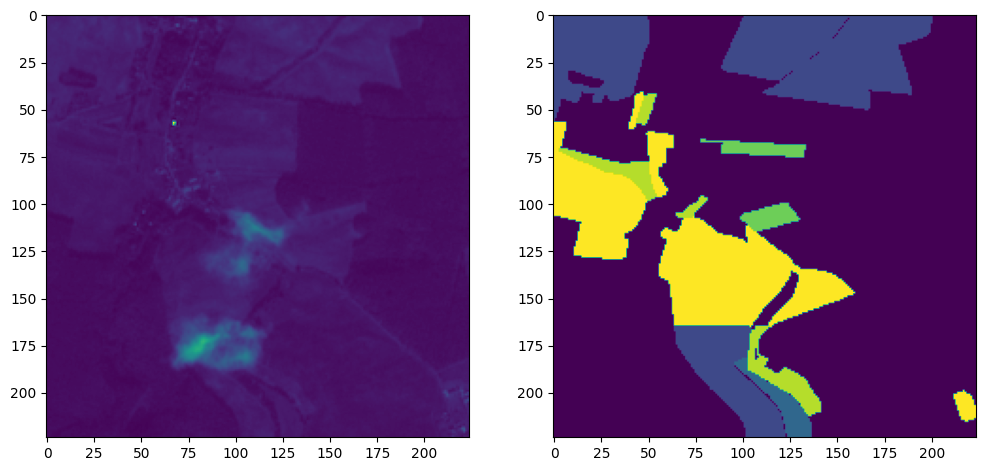

In [ ]:
import matplotlib.pyplot as plt
print(indexes[0])
batch_sample = train_seq[0][0]

smp_idx = 15
img_sample = batch_sample[smp_idx]
mask_sample = train_seq[0][1][smp_idx]

print(len(train_seq))
print(img_sample.shape)
print(mask_sample.shape)


figure, axarr = plt.subplots(1, 2)
figure.set_size_inches((12,12))

axarr[0].imshow(img_sample[..., 0])
axarr[1].imshow(np.argmax(mask_sample,axis=-1))

plt.show()

# Model definition

In [ ]:
!pip install transunet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=0056e67ccae70b9dff2bbcfdd41410572bff3b9f438a2521ed514d163edbd99e
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [ ]:
from transunet import TransUNet

model = TransUNet(
    image_size = 224, 
    pretrain = True,
    num_classes = len(CLASSES)+1, # All crop type classes + background class
    final_act = 'softmax',
    freeze_enc_cnn=False,
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from keras import backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1e-7):
    print(y_true.shape)
    n_classes = y_pred.shape[-1]
    y_true_f = K.flatten(tf.one_hot(y_true, n_classes))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_dice_loss(y_true, y_pred):
    n_classes = y_pred.shape[-1]
    y_pred_oh = tf.one_hot(y_pred, n_classes)
    loss = 0.0
    for i in range(0, n_classes):
        loss += dice_loss(y_true[..., i:i+1], y_pred_oh[..., i:i+1])
    return loss / n_classes

In [ ]:
masks = [
    afro_mask,
    germ_mask,
]

classes_freqs = {}
for mask in masks:
    unique, counts = np.unique(mask, return_counts=True)
    for i in range(len(unique)):
        if unique[i] not in classes_freqs:
            classes_freqs[unique[i]] = 0
        classes_freqs[unique[i]] = classes_freqs[unique[i]] + counts[i]
total_values = float(sum(classes_freqs.values()))
for key in classes_freqs.keys():
    classes_freqs[key] = (1.0 / classes_freqs[key]) * (total_values / 13.0)

classes_freqs

In [ ]:
base_batch_size = 24
base_learning_rate = 0.01
learning_rate = base_learning_rate * train_batch_size / base_batch_size
optim = tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, weight_decay=0.0001)
model.compile(
    optimizer=optim, 
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.13),
     metrics=[
        'categorical_accuracy',
    ]
)

Epoch 1/20
284/284 - 392s - loss: 1.8999 - categorical_accuracy: 0.5258 - val_loss: 2.5367 - val_categorical_accuracy: 0.4823 - 392s/epoch - 1s/step
Epoch 2/20
284/284 - 342s - loss: 1.6773 - categorical_accuracy: 0.6065 - val_loss: 2.2254 - val_categorical_accuracy: 0.5154 - 342s/epoch - 1s/step
Epoch 3/20
284/284 - 346s - loss: 1.4586 - categorical_accuracy: 0.7185 - val_loss: 1.3646 - val_categorical_accuracy: 0.7682 - 346s/epoch - 1s/step
Epoch 4/20
284/284 - 339s - loss: 1.2694 - categorical_accuracy: 0.8076 - val_loss: 1.2274 - val_categorical_accuracy: 0.8230 - 339s/epoch - 1s/step
Epoch 5/20
284/284 - 386s - loss: 1.1515 - categorical_accuracy: 0.8578 - val_loss: 1.1295 - val_categorical_accuracy: 0.8678 - 386s/epoch - 1s/step
Epoch 6/20
284/284 - 382s - loss: 1.0853 - categorical_accuracy: 0.8847 - val_loss: 1.0845 - val_categorical_accuracy: 0.8838 - 382s/epoch - 1s/step
Epoch 7/20
284/284 - 381s - loss: 1.0397 - categorical_accuracy: 0.9019 - val_loss: 1.0591 - val_categoric

KeyError: ignored

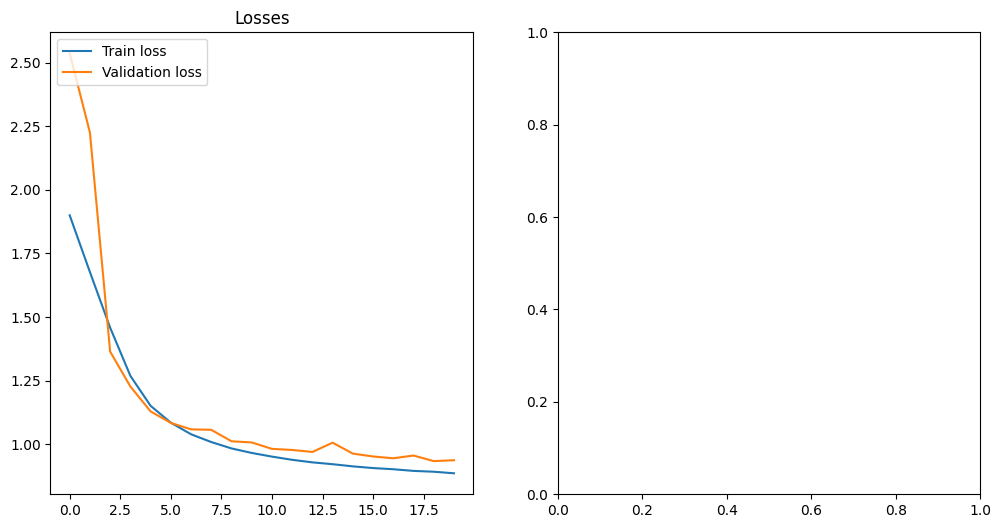

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/dimploma/transunet_test/transunet_acc_{val_categorical_accuracy:.4f}.h5", save_best_only=True, monitor='val_categorical_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3),
]

training = model.fit(train_seq, validation_data=val_seq, epochs=20, callbacks=callbacks, verbose=2)


fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].plot(training.history['loss'])
axes[0].plot(training.history['val_loss'])
axes[0].set_title('Losses')
axes[0].legend([ 'Train loss',  'Validation loss'], loc='upper left')

axes[1].plot(training.history['sparse_categorical_accuracy'])
axes[1].plot(training.history['val_sparse_categorical_accuracy'])
axes[1].set_title('Sparse Categorical Accuracy')
axes[1].legend([ 'Train Sparse Categorical Accuracy',  'Validation Sparse Categorical Accuracy'], loc='upper left')

# Results

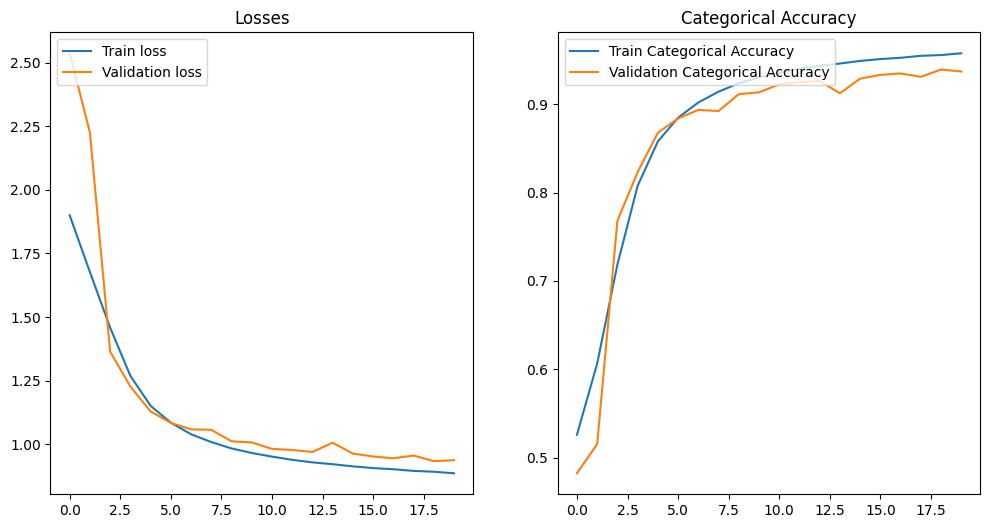

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].plot(training.history['loss'])
axes[0].plot(training.history['val_loss'])
axes[0].set_title('Losses')
axes[0].legend([ 'Train loss',  'Validation loss'], loc='upper left')

axes[1].plot(training.history['categorical_accuracy'])
axes[1].plot(training.history['val_categorical_accuracy'])
axes[1].set_title('Categorical Accuracy')
axes[1].legend([ 'Train Categorical Accuracy',  'Validation Categorical Accuracy'], loc='upper left')

In [ ]:
from sklearn.metrics import classification_report

model.load_weights("/content/drive/MyDrive/dimploma/transunet_test/transunet_acc_0.9392.h5")

preds = np.array([])
test_labels = np.array([])
for i in range(len(val_seq) // 4):
    x_test, y_test = val_seq[i]
    prediction = np.argmax(model.predict(x_test[..., :10]), axis=-1).flatten()
    preds = np.append(preds, prediction)
    label =  np.argmax(y_test[..., :10], axis=-1).flatten()
    test_labels = np.append(test_labels, label)

1/1 [==============================] - 0s 278ms/step


In [ ]:
print(classification_report(test_labels, preds, target_names = ['Nothing']+CLASSES[:9]))

              precision    recall  f1-score   support

     Nothing       0.97      0.97      0.97  11291917
       Wheat       0.96      0.96      0.96   2819029
         Rye       0.94      0.95      0.95   1817050
      Barley       0.94      0.95      0.95   1104689
        Oats       0.92      0.93      0.93    214496
        Corn       0.96      0.95      0.96   2335727
   Oil Seeds       0.96      0.97      0.96   2377128
  Root Crops       0.92      0.85      0.88     93565
     Meadows       0.86      0.88      0.87   1040061
Forage Crops       0.92      0.92      0.92    990818

    accuracy                           0.96  24084480
   macro avg       0.94      0.93      0.93  24084480
weighted avg       0.96      0.96      0.96  24084480

